In [1]:

# Remember to login to wandb!
import sys
import os 
import torch
import matplotlib.pyplot as plt
import copy 
import numpy as np
import itertools
# Append module directory for imports
parent_dir = os.path.expanduser('../eigenestimation/eigenestimation')

from eigenestimation.evaluation.networks import DrawNeuralNetwork
from eigenestimation.eigenmodel.eigenmodel import EigenModel
from eigenestimation.utils.loss import MSELoss
from eigenestimation.utils.uniform_models import ZeroOutput
from eigenestimation.toy_models.data import GenerateTMSInputs
from eigenestimation.toy_models.parallel_serial_network import CustomMLP
from torch import Tensor

import figure_names

In [2]:
model_path = "../outputs/toy_models/squared.pt"
eigenmodel_path = f"../outputs/eigenmodels/squared.pt"
model = torch.load(model_path)['model']

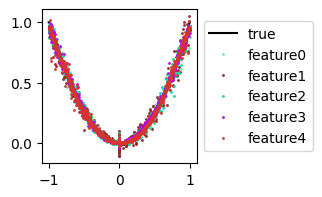

In [3]:
# Load model and data

n_features = model.layers[0].in_features

X = GenerateTMSInputs(num_features=n_features, num_datapoints=10000, sparsity=.05)
X = X * (2*torch.rand_like(X).round() - 1)
#X = X[(X!=0).sum(dim=-1)==1,:]
Y = X**2
Y_pred = model(X)

plt.figure(figsize=(2,2))
np.random.seed(42)

X_true = np.linspace(-1,1,1000)
Y_true = X_true**2
plt.plot(X_true, Y_true, 'k-', label='true')


for i in range(X.shape[1]):
    # Pick a random color
    color = np.random.rand(3,)
    plt.plot(X[:, i].cpu().detach().numpy(), Y_pred[:,i].cpu().detach().numpy(), '.', markersize=2, color=color, label=f"feature{i}")
    
# Put legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
    

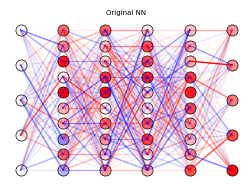

In [71]:
model_params = dict(model.named_parameters())
weights = {k:v for k,v in model_params.items() if 'bias' not in k}
weights = {str(i):v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'bias' in k}
biases = {str(i):v for i,v in enumerate(biases.values())}

f, ax = plt.subplots(figsize=(3,2))
DrawNeuralNetwork(weights, biases, "Original NN", ax=ax)
plt.show()

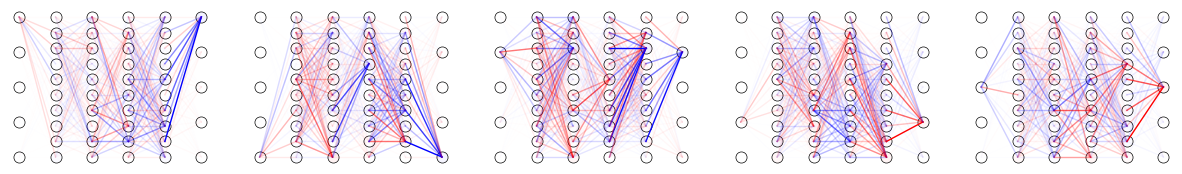

In [5]:
eigenmodel = torch.load(eigenmodel_path)['model']

model_params = eigenmodel.reconstruct_network()
weights = {k:v for k,v in model_params.items() if 'bias' not in k}
weights = {str(i):10*v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'bias' in k}
biases = {str(i):v for i,v in enumerate(biases.values())}

f, axes = plt.subplots(figsize=(3*eigenmodel.n_features,2), nrows=1, ncols=eigenmodel.n_features)
axes_flat = axes.flatten()
for i, network in enumerate(eigenmodel.construct_subnetworks()):
    
    weights = {k:v for k,v in network.items() if 'bias' not in k}
    weights = {str(i):10*v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in network.items() if 'bias' in k}
    biases = {str(i):v for i,v in enumerate(biases.values())}

    DrawNeuralNetwork(weights, biases,ax=axes_flat[i])
    # Save figure
f.savefig(figure_names.squared_subnetworks, bbox_inches='tight', transparent=True)
f.savefig(figure_names.squared_subnetworks.replace('.pdf', '.svg'), bbox_inches='tight', transparent=True)
plt.show()


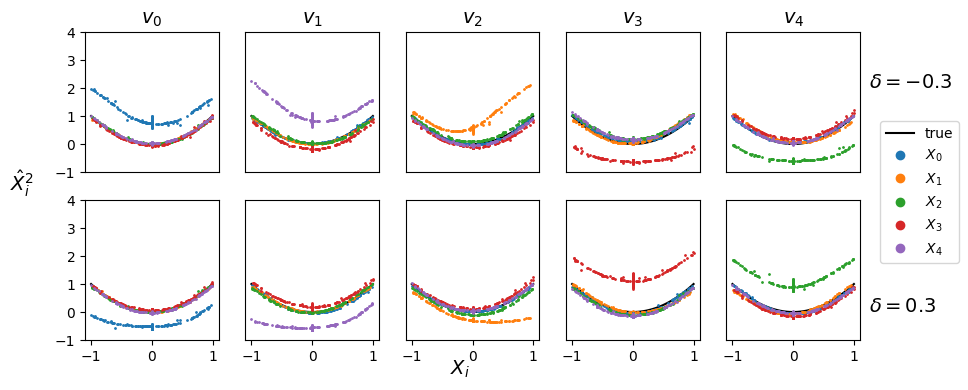

In [6]:
def PerturbAndGraph(delta_values, filename, X, ylim=(-1,2),):
    feature_coefficients = torch.zeros(eigenmodel.n_features).to('cuda')
    toy_model = copy.deepcopy(eigenmodel.model)
    orig_y = toy_model(X)
    f, ax = plt.subplots(len(delta_values),eigenmodel.n_features, figsize=(2*eigenmodel.n_features,2*len(delta_values)))
    for feature_idx in range(eigenmodel.n_features):
        for row_i, feature_coeff in enumerate(delta_values):
            # Subplot with 2 columns
            feature_coefficients = torch.zeros(eigenmodel.n_features).to('cuda')
            feature_coefficients[feature_idx] = feature_coeff
            reconstruction = eigenmodel.add_to_network(feature_coefficients)
            # Repalce toy model parameters with model_params
            toy_model.load_state_dict(reconstruction)
            y = (toy_model(X) ).cpu().detach().numpy()
            ax[row_i,feature_idx].plot(np.linspace(-1,1,100), np.linspace(-1,1,100)**2, 'k-', label='true')
            for i in range(y.shape[1]):
                ax[row_i,feature_idx].plot(X[:,4-i].cpu().detach().numpy(), y[:,4-i], '.', label=f"${{X}}_{i}$",  markersize=2) #, bins=np.linspace(-.1,.1,100), alpha=.5)
                ax[row_i,feature_idx].set_ylim(ylim)

            ax[0,feature_idx].set_title(f"$v_{feature_idx}$", fontsize=14)
            ax[0,feature_idx].set_xticks([])
            # If column is not 0, remove y ticks
            if feature_idx != 0:
                ax[row_i,feature_idx].set_yticks([])
                
            if row_i != len(delta_values)-1:
                ax[row_i,feature_idx].set_xticks([])


    # Set over all figure x and y axes
    f.supylabel('$\hat{X}_{i}^2$', rotation=0, x=.05, fontsize=14)
    # Move sup y label closer to the figure

    ax[0,-1].text(s=f'$\delta={delta_values[0]}$', y=2,x=1.25, fontsize=14)
    ax[1,-1].text(s=f'$\delta={delta_values[1]}$', y=0,x=1.25, fontsize=14)


    f.supxlabel('${X}_{i}$', rotation=0, fontsize=14)
            
            
    plt.legend(loc='lower left', bbox_to_anchor=(1.1, 0.50), fontsize=10, markerscale=6)

    # Save figure
    plt.savefig(filename, bbox_inches='tight', transparent=True)
    f.savefig(filename.replace('.pdf', '.svg'), bbox_inches='tight', transparent=True)
    plt.show()
    
PerturbAndGraph([-.3,.3],figure_names.squared_intervention, X[:500],ylim=(-1,4))


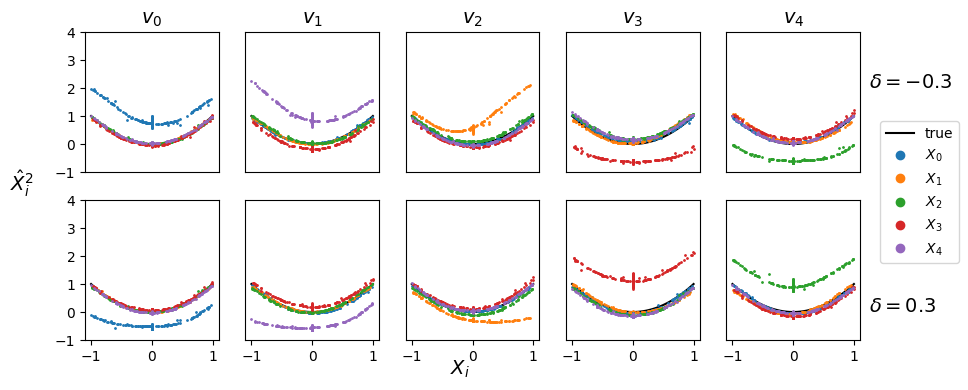

In [7]:
PerturbAndGraph([-.3,.3],figure_names.squared_intervention, X[:500],ylim=(-1,4))


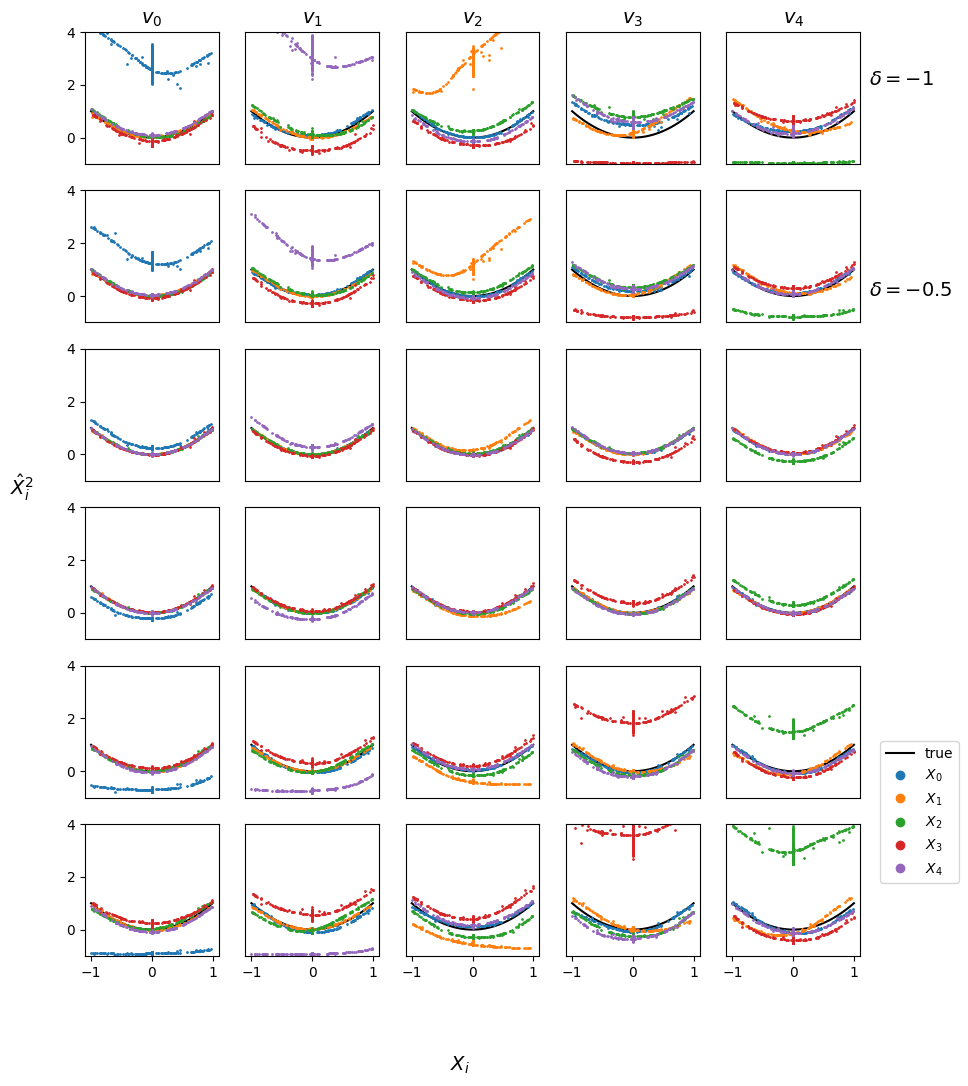

In [8]:
PerturbAndGraph([-1,-.5,-.1,.1, .5,1], figure_names.squared_intervention_more_deltas, X[:500],ylim=(-1,4))


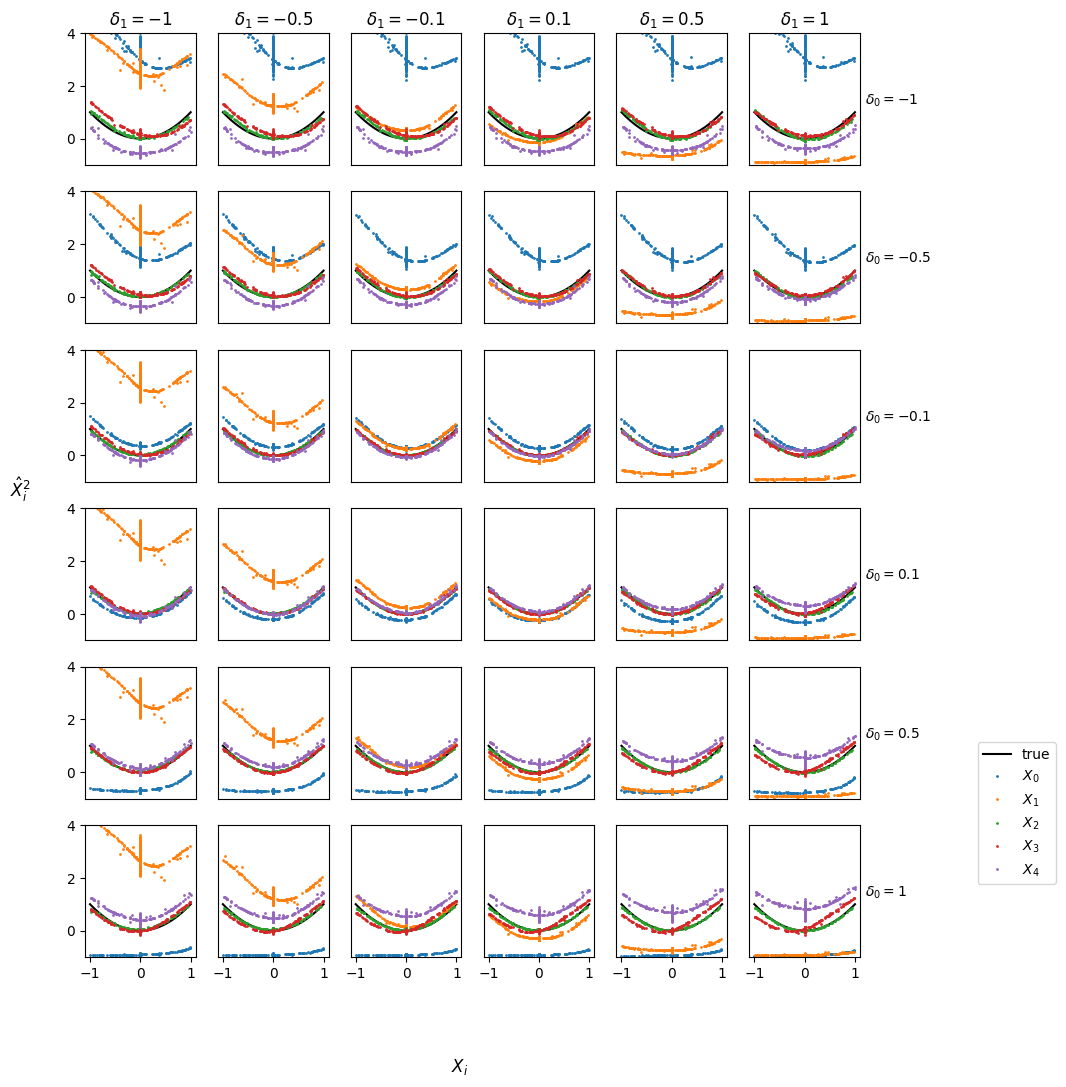

In [9]:
def PerturbAndGraphMultiFeatures(delta_values, filename, X, ylim=(-1,2),):
    
    feature_1_idx = 0
    feature_2_idx = 1
    
    feature_coefficients = torch.zeros(eigenmodel.n_features).to('cuda')
    toy_model = copy.deepcopy(eigenmodel.model)
    orig_y = toy_model(X)
    f, ax = plt.subplots(len(delta_values),len(delta_values), figsize=(10,2*len(delta_values)))
    for col_i, feature_coeff_0 in enumerate(delta_values):
        for row_i, feature_coeff_1 in enumerate(delta_values):
            # Subplot with 2 columns
            feature_coefficients = torch.zeros(eigenmodel.n_features).to('cuda')
            feature_coefficients[feature_1_idx] = feature_coeff_0
            feature_coefficients[feature_2_idx] = feature_coeff_1
            reconstruction = eigenmodel.add_to_network(feature_coefficients)
            # Repalce toy model parameters with model_params
            toy_model.load_state_dict(reconstruction)
            y = (toy_model(X) ).cpu().detach().numpy()
            
            ax[row_i,col_i].plot(np.linspace(-1,1,100), np.linspace(-1,1,100)**2, 'k-', label='true')
            for i in range(y.shape[1]):
                ax[row_i,col_i].plot(X[:,-i].cpu().detach().numpy(), y[:,-i], '.', label=f"${{X}}_{i}$",  markersize=2) #, bins=np.linspace(-.1,.1,100), alpha=.5)
                ax[row_i,col_i].set_ylim(ylim)

            ax[0,col_i].set_xticks([])
            # If column is not 0, remove y ticks
            if col_i != 0:
                ax[row_i,col_i].set_yticks([])
                
            if row_i != len(delta_values)-1:
                ax[row_i,col_i].set_xticks([])


    # Set over all figure x and y axes
    f.supylabel('$\hat{X}_{i}^2$', rotation=0, x=.05)
    # Move sup y label closer to the figure

    for i, delta_value in enumerate(delta_values):
        ax[i,-1].text(s=f'$\delta_{feature_1_idx}={delta_value}$', y=1.3,x=1.2)
        ax[0,i].set_title(f'$\delta_{feature_2_idx}={delta_values[i]}$')


    f.supxlabel('${X}_{i}$', rotation=0)
            
            
    plt.legend(loc='lower left', bbox_to_anchor=(2, 0.5))

    # Save figure
    plt.savefig(filename, bbox_inches='tight', transparent=True)
    f.savefig(filename.replace('.pdf', '.svg'), bbox_inches='tight', transparent=True)
    plt.show()


PerturbAndGraphMultiFeatures([-1,-.5,-.1,.1, .5,1], figure_names.squared_intervention_multi_features, X[:500],ylim=(-1,4))

In [ ]:
for name in eigenmodel.low_rank_decode:
    if '0.' in name or ('4.' in name):
        eigenmodel.low_rank_decode[name] = torch.zeros_like(vec) for vec in eigenmodel.low_rank_decode[name]]
        
        eigenmodel.low_rank_encode[name] = [torch.zeros_like(vec) for vec in eigenmodel.low_rank_encode[name]]
        
PerturbAndGraph([-1,-.5,-.1,.1, .5,1], figure_names.squared_intervention_middle_weights, X[:500],ylim=(-1,4))

TypeError: zeros_like(): argument 'input' (position 1) must be Tensor, not str

----


# Many Features


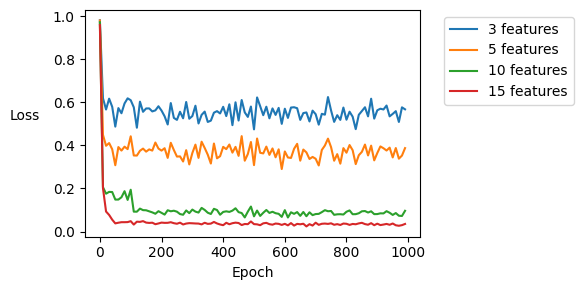

In [11]:
# Get loss metrics from a wandb run
import wandb
import pandas as pd
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 3))
for i in [3,5,10,15]:
    project_path = f"brianna-chrisman-2024/squared-network-eigenmodel-features{i}"  # entity/project
    api = wandb.Api()

    #project_path = f"brianna-chrisman-2024/tms-eigenmodel"  # entity/project
    runs = api.runs(project_path)

    # Get the latest run (first in the list)
    latest_run = runs[len(runs)-1]

    # Convert history (logged metrics) to a DataFrame
    history = latest_run.history()


    # Filter only loss metrics (adjust based on your naming convention)
    loss_columns = 'train/loss'
    loss_metrics = history[loss_columns]  # Include step count
    epochs = history['epoch']  # Include step count
    epochs = epochs[loss_metrics.notna()]
    loss_metrics = loss_metrics[loss_metrics.notna()]
    plt.plot(epochs, loss_metrics, label=f'{i} features')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss', rotation=0, labelpad=20)
plt.tight_layout()
plt.savefig(figure_names.squared_features_vs_loss, transparent=True, bbox_inches='tight')
plt.savefig(figure_names.squared_features_vs_loss.replace('.pdf', '.svg'), transparent=True, bbox_inches='tight')
plt.show()


------------N_FEATURES 3------------


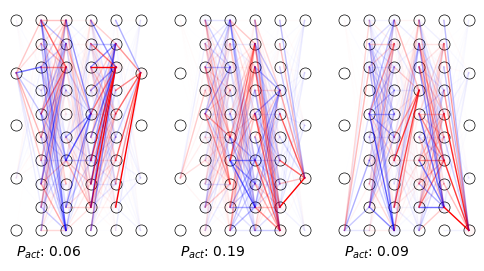

------------N_FEATURES 5------------


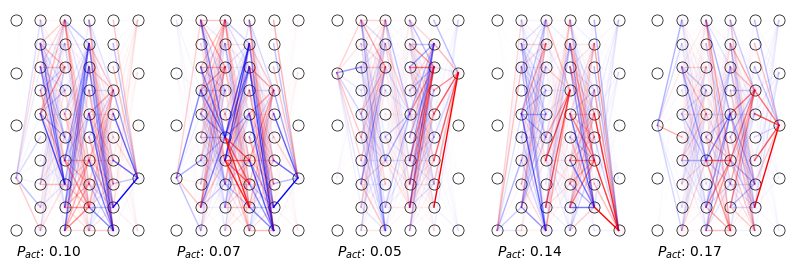

------------N_FEATURES 10------------


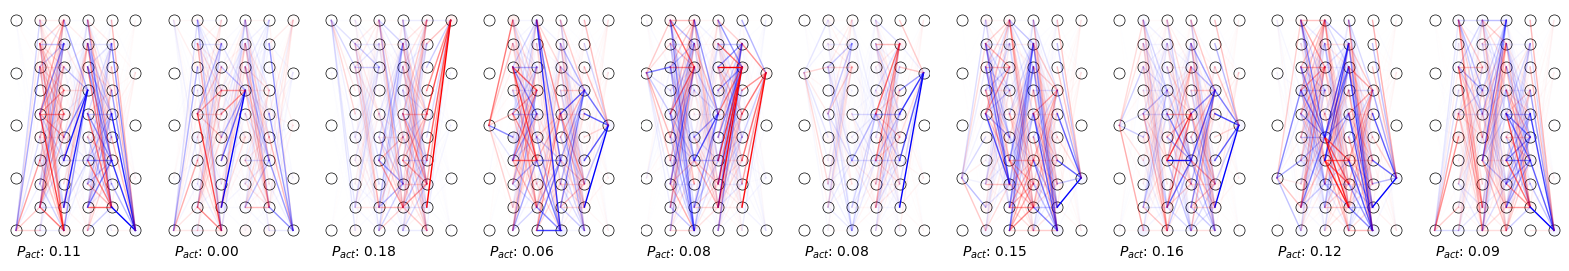

------------N_FEATURES 15------------


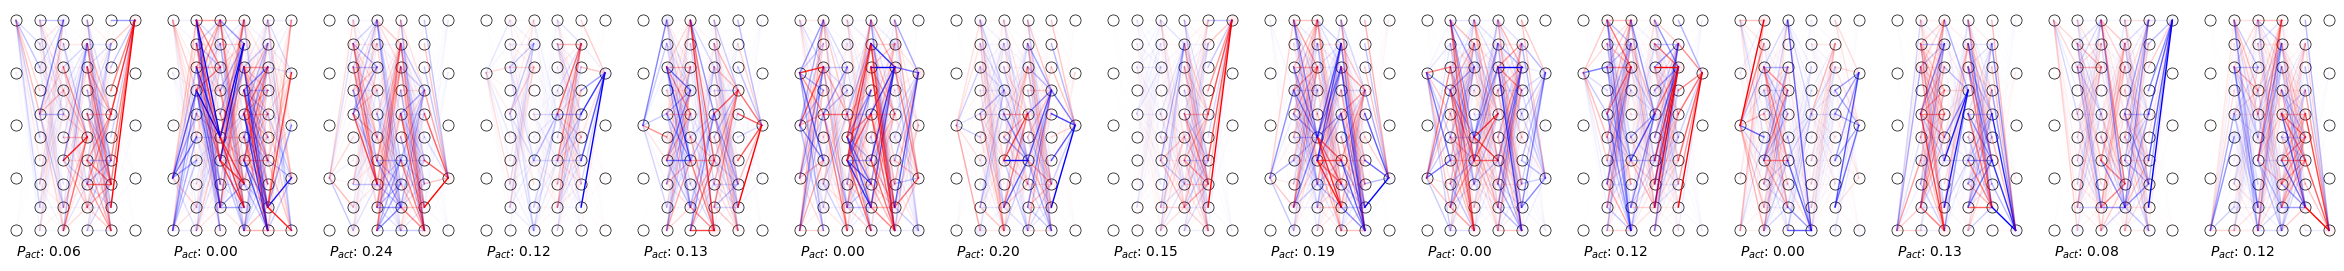

In [12]:
for n_features in [3,5,10,15]:
    eigenmodel_path = f"../outputs/eigenmodels/squared_features{n_features}.pt"
    print(f'------------N_FEATURES {n_features}------------')
    checkpoint = torch.load(eigenmodel_path)
    eigenmodel = checkpoint['model']
    f, axes_flat = plt.subplots(ncols=eigenmodel.n_features, figsize=(2*eigenmodel.n_features, 3))
    ax_flat = axes_flat.flatten()
    frac_activated = checkpoint['frac_activated'].cpu().detach().numpy()
    for i, network in enumerate(eigenmodel.construct_subnetworks()):
        
        weights = {k:v for k,v in network.items() if 'bias' not in k}
        weights = {str(i):10*v for i,v in enumerate(weights.values())}

        biases = {k:v for k,v in network.items() if 'bias' in k}
        biases = {str(i):v for i,v in enumerate(biases.values())}

        DrawNeuralNetwork(weights, biases, ax=axes_flat[i])
        axes_flat[i].text(s= f'$P_{{act}}$: {frac_activated[i].item():.2f}', size=10, x=1, y=0)
        # Save figure
    f.savefig(figure_names.squared_decompositions % n_features, bbox_inches='tight', transparent=True)
    f.savefig(figure_names.squared_decompositions.replace('.pdf', '.svg') % n_features, bbox_inches='tight', transparent=True)
    plt.show()
    
    
    
